## Forecasting prices for new listings

As has already been motivated in `airbnb_amsterdam.ipynb` notebook, it is important that price for a new listing is properly chosen. In this document, we use simple machine learning models for predicting these prices. We address the following research points:
- Can the prices for future listings be actually predicted using the available data?
- What are the most important features to model with?
- Which model is a better/appropriate model to predict the prices?

In [1]:
# importing the necessary modules
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer 

In [2]:
from utils.price_mapper import price_mapper

The original data contains three `csv` files, namely `listing_details.csv`, `review_details.csv` and `calendar_details.csv`. In this study, we only use the first file contain information related to the listings and use ML methods to predict price of new listings based on the data of this file. Summary of the data follows below.

In [3]:
# Reading the data from csv files 
df_listing_details = pd.read_csv('../Data/amsterdam/listings_details.csv')
#df_review_details = pd.read_csv('../Data/amsterdam/reviews_details.csv')
#df_calender_details = pd.read_csv('../Data/amsterdam/calendar_details.csv')

In [15]:
df_listing_details.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20200818040300,2020-08-19,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi<br />...,"Indische Buurt (""Indies Neighborhood"") is a ne...",https://a0.muscache.com/pictures/10272854/8dcc...,3159,https://www.airbnb.com/users/show/3159,...,10.0,10.0,9.0,10.0,t,1,0,1,0,2.00
1,20168,https://www.airbnb.com/rooms/20168,20200818040300,2020-08-18,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,Located just in between famous central canals....,https://a0.muscache.com/pictures/69979628/fd6a...,59484,https://www.airbnb.com/users/show/59484,...,10.0,10.0,10.0,9.0,t,3,1,2,0,2.67
2,25428,https://www.airbnb.com/rooms/25428,20200818040300,2020-08-18,Lovely apt in City Centre (w.lift) near Jordaan,Lovely apt in Centre ( lift & fireplace) near ...,NaN,https://a0.muscache.com/pictures/138431/7079a9...,56142,https://www.airbnb.com/users/show/56142,...,10.0,10.0,10.0,10.0,f,1,1,0,0,0.16
3,27886,https://www.airbnb.com/rooms/27886,20200818040300,2020-08-18,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.",https://a0.muscache.com/pictures/02c2da9d-660e...,97647,https://www.airbnb.com/users/show/97647,...,10.0,10.0,10.0,10.0,t,1,0,1,0,2.09
4,28871,https://www.airbnb.com/rooms/28871,20200818040300,2020-08-19,Comfortable double room,<b>The space</b><br />In a monumental house ri...,"Flower market , Leidseplein , Rembrantsplein",https://a0.muscache.com/pictures/160889/362340...,124245,https://www.airbnb.com/users/show/124245,...,10.0,10.0,10.0,10.0,f,2,0,2,0,2.74


In [5]:
df_listing_details['review_scores_location'].mean()

9.51458983299688

#### Missing value analysis

We perform missing data analysis and drop columns where more than 70% of the data is missing. Note below the names of the cols that have been dropped.

In [6]:
missing_cols_listings = df_listing_details.isnull().mean()
# we will drop all the columns which does not have more than 70% of the data.
missing_gr_07 = df_listing_details .columns[missing_cols_listings > 0.7]
print([col + ' ' + str(missing_cols_listings[col]) for col in missing_gr_07])
df_listing_details = df_listing_details.drop(missing_gr_07, axis=1)


['neighbourhood_group_cleansed 1.0', 'bathrooms 1.0', 'calendar_updated 1.0', 'license 1.0']


After columns with more than 70% data missing are treated, we further analyze the remaining columns and would perform additional treatments in columns where null values are close to 70%. For this, we show below the columns where more than 30% of the data is missing.

In [7]:
missing_cols_listings = df_listing_details.isnull().mean()
missing_gr_03 = df_listing_details.columns[missing_cols_listings > 0.3]
print([col + ' ' + str(missing_cols_listings[col]) for col in missing_gr_03])

['neighborhood_overview 0.3386986120639612', 'host_about 0.42202754762784317', 'host_response_time 0.6661037521768959', 'host_response_rate 0.6661037521768959', 'host_acceptance_rate 0.3995989234260383', 'host_neighbourhood 0.3256636234102063', 'neighbourhood 0.3386986120639612']


As can be seen there are columns where more than 60% of the data is missing. First we correct these columns so that mathematical operations can be performed on these. For example, the column `host_response_rate` contains numbers with `%` sign appended at the end. We remove the `%` sign from all the entries of this column. Further, we impute mean for the missing entries. For `host_response_time`, we replace all empty entries with `not provided`, and treat this entry as a category.

In [8]:
# it seems this column's elemts are not uniform, some have % some are not. lets make them uniform before missing value analysis.
df_listing_details['host_response_rate']

0         NaN
1         NaN
2        100%
3        100%
4        100%
         ... 
18944     NaN
18945     NaN
18946     50%
18947     NaN
18948     NaN
Name: host_response_rate, Length: 18949, dtype: object

In [9]:
df_listing_details[['host_response_rate']] = df_listing_details['host_response_rate'].apply(lambda col: float(str(col).replace("%", "")))
df_listing_details['host_response_rate'] = df_listing_details['host_response_rate'].fillna(np.mean(df_listing_details['host_response_rate']))
df_listing_details['host_response_time'] = df_listing_details['host_response_time'].fillna('not provided')

The different types of features require different treatments. Thus, we separate them based on their types into different sets, as can be seen below. Further, data types such as boolean and categorical will be expanded into multiple columns each, based on the possible values that each of these variables can hold.

In [14]:
# Gathering the different types of Non-numerical features
categorical_attributes = ['host_location', 'host_response_time', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type']
full_text_attributes = ['name', 'description', 'neighborhood_overview', 'host_about']
dropping_attributes = ['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'last_scraped', 'host_name', 'calendar_last_scraped']
date_attributes = ['host_since', 'first_review', 'last_review']
bool_attributes = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
array_attributes = ['host_verifications', 'amenities']
money_attributes = ['price']


list_non_numeric = categorical_attributes +full_text_attributes + dropping_attributes + date_attributes + bool_attributes + array_attributes + money_attributes
    
listings_categorical = df_listing_details[list_non_numeric]
# We one-hot-encode Categorical attributes with dummies
listings_categorical_dummies = pd.get_dummies(listings_categorical[categorical_attributes])

# Date types are factorized into numerical ints
listings_date_factors = listings_categorical[date_attributes].apply(lambda col: pd.factorize(col, sort=True)[0])

# Boolean types are replaced with a 0 or 1
def repl_f_t(l):
    l = l.replace('f', 0)
    l = l.replace('t', 1)
    l = l.fillna(np.mean(l))
    return l

def imputation(df):
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer.fit_transform(df)
    return df
    
listings_bool_replaced = listings_categorical[bool_attributes].apply(lambda col: repl_f_t(col))
listings_bool_replaced = imputation(listings_bool_replaced)

# Arrays are a little complicated. First, we remove the extraneous characters in them
def get_arr(l):
    l = l.str.replace('[', '');
    l = l.str.replace(']', '');
    l = l.str.replace('{', '');
    l = l.str.replace('}', '');
    l = l.str.replace("'", '');
    l = l.str.replace('"', '');
    return l;
listings_arr_fixed = df_listing_details[array_attributes].apply(lambda col: get_arr(col));

# Next, we get encoded one-hot-dummies for each value in them, prefixed by the column name.
array_dummy_arrs = [];

for col in listings_arr_fixed.columns:
    dummy_arrs = listings_arr_fixed[col].str.get_dummies(sep=',');
    dummy_arrs = dummy_arrs.add_prefix(col + '_');
    array_dummy_arrs.append(dummy_arrs);
    
listings_arr_fixed = pd.concat(array_dummy_arrs, axis=1);

# Currency attributes can be converted to Floats by removing the dollar symbol and commas
#listings_money_floats = listings_categorical[money_attributes].apply(lambda col: col.str.replace("$", "").str.replace(",","").astype('float'))

listings_money_floats = listings_categorical[money_attributes].apply(lambda col:col.map(price_mapper))

# Now, we combine all these attributes together.
listings_all_model = pd.concat([listings_categorical_dummies, listings_date_factors, listings_bool_replaced, listings_arr_fixed, listings_money_floats], axis=1)
# And make sure that ints are used where they can be
#listings_all_cats[list(listings_categorical_dummies.columns) + list(listings_arr_fixed.columns) + list(listings_bool_replaced.columns)] = listings_all_cats[list(listings_categorical_dummies.columns) + list(listings_arr_fixed.columns) + list(listings_bool_replaced.columns).astype('int')]

In [16]:
listings_all_model.shape

(18949, 957)

Note that we now have 957 features. It is of interest to understand whether all of these features are actually important or not. 

#### Analysing importance of features for modeling

We build `Feature Importance` score for each feature of the dataset, higher this score, more relevant is the feature towards the prediction of the output variable. For this purpose, we will use Extra Tree Classifier for extracting the top 25 features from the dataset that are most relevant for the output.

In [17]:
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

from sklearn import metrics
from sklearn import linear_model
from sklearn import ensemble
from IPython.core.display import HTML

In [18]:
# splitting the training and test sets with a 60% and 40% size of original
split_data = listings_all_model.drop(['price'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(split_data,
                                                listings_all_model.price, 
                                                test_size=0.3,
                                                train_size = 0.7,
                                                random_state=13)

In [19]:
# example of correlation feature selection for numerical data
 
# feature selection
def select_features(X_train, y_train, X_test, k = "all"):
    # configure to select all features
    feature_selector = SelectKBest(score_func=f_regression, k=k)
    # learn relationship from training data
    feature_selector.fit(X_train, y_train)
    # transform train input data
    feature_selected_X_train = feature_selector.transform(X_train)
    # transform test input data
    feature_selected_X_test= feature_selector.transform(X_test)
    return feature_selected_X_train,feature_selected_X_test, feature_selector


/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


property_type_Lighthouse                           802.917758
room_type_Private room                             507.241279
room_type_Entire home/apt                          464.158317
property_type_Private room in apartment            335.283863
amenities_ Dryer                                   237.928961
                                                      ...    
host_location_Belgrano, Buenos Aires, Argentina      0.000049
neighbourhood_Amsterdam, Zeedijk, Netherlands        0.000049
host_neighbourhood_Landelijk Noord                   0.000030
host_location_US                                     0.000017
amenities_ Heating                                   0.000012
Length: 825, dtype: float64


<AxesSubplot:title={'center':'Feature Importance'}>

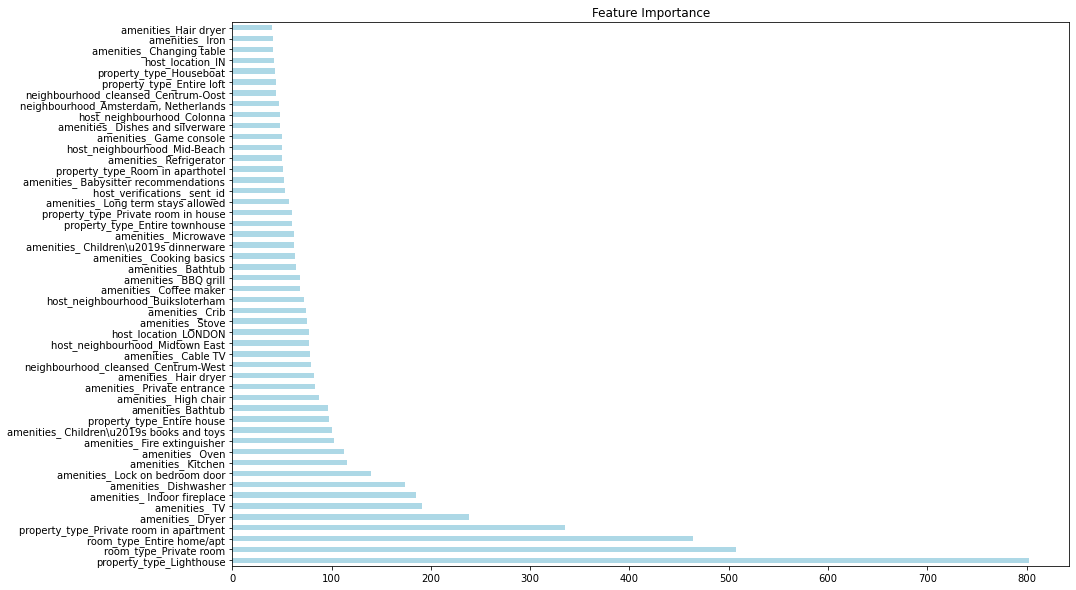

In [20]:
# feature selection
X_train_fs, X_test_fs, feature_selector = select_features(X_train, y_train, X_test, k='all')
#feature_selector.scores_ = feature_selector.scores_[~(np.isnan(feature_selector.scores_))] 
#feature_selector.scores_[::-1].sort()
feature = pd.Series(feature_selector.scores_, index = X_train.columns).sort_values(ascending = False)
feature  = feature [~feature.isnull()]
print(feature)
# summarize feature importance
feature[0:50].plot(kind = 'barh',
              figsize = (15,10),
              color = 'LightBlue',
              title = 'Feature Importance')

Above, we show the importance score for the top 50 features, higher the better. From these, we take the best 25 features for further study.

In [22]:
feature = feature[0:25]
important_features = list(feature.keys()[i] for i in range(len(feature.keys())))

Next, we build the train and test sets based on only the important features.

In [23]:
X_train_fs = X_train[important_features]
X_test_fs = X_test[important_features]

In [29]:
X_train_fs.shape

(13264, 25)

The complete example of fitting a RandomForestClassifier and summarizing the calculated feature importance scores is listed below.

### Selection of subsets of features from the list of 25 features

Of the features that we have now in the train and test sets, how do we proceed with training the model with optimal choice of feature sets?

Instead of guessing, we can systematically test a range of different numbers of selected features and discover which results in the best performing model. This is called a grid search, where the k argument to the SelectKBest class can be tuned.

It is a good practice to evaluate model configurations on regression tasks using repeated stratified k-fold cross-validation. We will use three repeats of 10-fold cross-validation via the RepeatedKFold class.


In [24]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
# define the evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

In [25]:
# define the pipeline to evaluate
model = LinearRegression()
fs = SelectKBest(score_func=f_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])

>0 nan (nan)
>1 -69.529 (3.167)
>2 -65.680 (2.504)
>3 -65.658 (2.499)
>4 -65.352 (2.481)
>5 -64.292 (2.565)
>6 -63.782 (2.568)
>7 -63.111 (2.603)
>8 -62.674 (2.734)
>9 -62.628 (2.643)
>10 -62.607 (2.648)
>11 -62.566 (2.599)
>12 -62.458 (2.643)
>13 -62.299 (2.707)
>14 -62.153 (2.679)
>15 -62.034 (2.668)
>16 -61.894 (2.565)
>17 -61.726 (2.499)
>18 -61.539 (2.491)
>19 -61.493 (2.469)
>20 -61.346 (2.532)
>21 -61.242 (2.573)
>22 -61.047 (2.515)
>23 -60.979 (2.538)
>24 -60.802 (2.600)
>25 -60.628 (2.543)


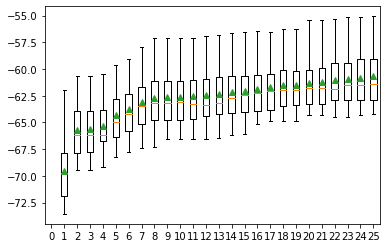

In [27]:
# define number of features to evaluate
from numpy import mean
from numpy import std
num_features = [i for i in range(X_train_fs.shape[1]-25, X_train_fs.shape[1]+1)]
# enumerate each number of features
results = list()
for k in num_features:
    # create pipeline
    model = LinearRegression()
    fs = SelectKBest(score_func=f_regression, k=k)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
    # evaluate the model
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X_train_fs, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results.append(scores)
    # summarize the results
    print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=num_features, showmeans=True)
pyplot.show()

Running the example grid searches different numbers of selected features using mutual information statistics, where each modeling pipeline is evaluated using repeated cross-validation.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

In the plot above, we visualize how the error reduces when one additional feature is included. We started with the feature having highest importance score. It was observed that while the error plot becomes almost flat after around 8th feature, each feature seems to reduce the error further. Thus, in this case, we move ahead with all the 25 features.

#### Baseline

We first create a baseline using DummyRegressor of scikit-learn.

In [32]:
## baseline
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_regr_error = metrics.median_absolute_error(y_test, dummy_regr.predict(X_test))
dummy_regr_error

52.090896411339

#### Linear regression and Ridge regression

In [39]:
# linear regression testing
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg_error = metrics.median_absolute_error(y_test, linear_reg.predict(X_test))

# ridge model testing
ridge = linear_model.Ridge()
ridge.fit(X_train, y_train)
ridge_error = metrics.median_absolute_error(y_test, ridge.predict(X_test))
print ("Linear Regression: " + str(linear_reg_error))
print ("Ridge: " + str(ridge_error))

Linear Regression: 40.606748260081105
Ridge: 40.27285153085586


From both, linear regression and ridge-regression results, it can be seen that the error in price prediction is approximately $40. We further analyse whether this price can be reduced through utilizing scikit learn's `Ensemble` and `GridSearchCV` methods. GridSearchCV is an exhausive search method over specified parameter values for an estimator.

For ensembling, we employ boosting techniques. Particularly, we want to focus on `AdaBoostRegressor`, `GradientBoostRegressor`, and `BaggingRegressor` for our estimators. AdaBoostRegressor is a meta-estimator that fits a regressor on the original dataset and then fits additional copies of the regressor utilizing different and adjusted weights of the errors. GradientBoostingRegressor allows for optimization of arbitrary differentiable loss functions, where in each stage a regression tree is fit on the negative gradient. BaggingRegressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original datasets and then aggregate their individual predictions to a final one. The benefit is that it reduces variance of black-box estimaor like a decision tree using randomization.

In [40]:
# gradient boosting regressor
param_names = ["n_estimators", "max_depth", "learning_rate", "loss", "min_samples_split"]
param_values = [[100,300,500], [1,2,3,4], [0.01, 0.02], ['ls', 'lad'], [1,2]]

parameters = dict(zip(param_names, param_values))
gbr = GridSearchCV(ensemble.GradientBoostingRegressor(), 
                   cv = 3, 
                   param_grid = parameters, 
                   scoring='neg_mean_squared_error')
preds = gbr.fit(X_train, y_train)
gbr_best_estimator = gbr.best_estimator_

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 500, in fit
    sample_weight_val, begin_at_stage, monitor, X_idx_sorted)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 557, in _fit_stages
    random_state, X_idx_sorted, X_csc, X_csr)
  File "/Users/dgupta/anaconda3/envs/env_debdev/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 212, in _fit_stage
    check_input=False, X_idx_sorted=X_idx_sorted

In [48]:
gbr_error = metrics.median_absolute_error(y_test, gbr_best_estimator.predict(X_test))
print ("gbr: " + str(gbr_error))

gbr: 40.61953255613608


We see from the above error that the gradient boosting regressor method does not reduce the overall median absolute error. We further visualize below the features in order of importance that have been identified by gradient boosting regressor.

<AxesSubplot:title={'center':'Feature Importance'}>

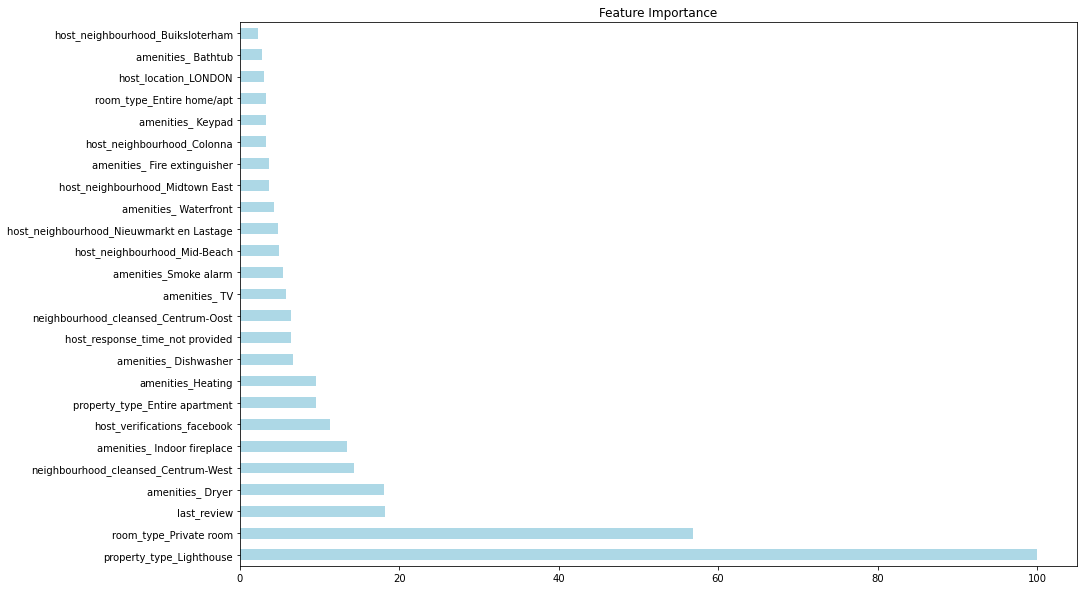

In [53]:
feature_importance = gbr_best_estimator.feature_importances_
feature_score = 100.0 * (feature_importance / feature_importance.max())

feature = pd.Series(feature_score, index = X_train.columns).sort_values(ascending = False)
feature  = feature [~feature.isnull()]
# summarize feature importance
feature[0:25].plot(kind = 'barh',
              figsize = (15,10),
              color = 'LightBlue',
              title = 'Feature Importance')

Next, we assess whether bagging can improve the performance of the predictor. 

In [43]:
param_names = ["n_estimators", "max_features", "bootstrap", "oob_score"]
param_values = [[100,500,1000], [1,5,10], [True, False], [False]]

parameters = dict(zip(param_names, param_values))
br = GridSearchCV(ensemble.BaggingRegressor(), 
                   cv = 3, 
                   param_grid = parameters, 
                   scoring='neg_mean_squared_error')
preds = br.fit(X_train, y_train)
br_best_estimator = br.best_estimator_

In [49]:
br_error = metrics.median_absolute_error(y_test, br_best_estimator.predict(X_test))
print ("Bagging Regressor: " + str(br_error))

Bagging Regressor: 51.672927771798044


From the score reported above, we see that the bagging regressor is not useful for the prediction, as it performs inferior to the other methods discussed above. Finally, we also experiment how random forest performs.

In [51]:
# random forest for feature importance on a classification problem
from sklearn.ensemble import RandomForestRegressor
# define the model
estimator = RandomForestRegressor()
# fit the model
rf = estimator.fit(X_train, y_train)

In [52]:
rf_error = metrics.median_absolute_error(y_test, rf.predict(X_test))
print ("Random Forest: " + str(rf_error))

Bagging Regressor: 34.230000000000004


We see here that the error is mae gets reduced when using random forest. Moreover, the mae reduces from 52 to 32 when compared to the dummy classifier baseline. This is almost a reduction of 33%. With improved regressors, this error can be reduced further, however, that is kept beyond the scope of this study. With this study, it is hoped to have been sufficiently demonstrated that the prices of future listings can be predicted. 